In [1]:
from PIL import Image
import skimage.io

import os
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import math 
import os
import shutil
import numpy as np
from datetime import datetime
import cv2

In [3]:
root = '/Users/MR ARCHITECT/MyFloorPlan/MyGenFloorPlan/'

In [4]:
purple = np.array([255, 27, 255, 255])
yellow = np.array([255, 255, 27, 255])
blue = np.array([27, 27, 255, 255])
red = np.array([255, 27, 27, 255])
lightblue = np.array([27, 255, 255, 255])
green = np.array([27, 255, 27, 255])
orange = np.array([255, 155, 27, 255])
white = np.array([255, 255, 255, 255])
black = np.array([0, 0, 0, 255])

rmFuncMap = {
    'bedroom': purple,
    'livingroom': yellow,
    'bathroom': blue,
    'kitchen': red,
    'storageroom': lightblue,
    'deckNporch': green,
    'corridor': orange,
    'background': white,
}

augmentedPath = Path(root + '/dataset/Augmented/')

pathA = augmentedPath / 'A'
pathB = augmentedPath / 'B'
newCombinedPath = augmentedPath / f"Combined_{datetime.now().strftime('%Y_%m_%d_%H_%M')}" 
newCombinedPath.mkdir(parents=True, exist_ok=True)

pathA_processed = augmentedPath / f"A_processed"
pathA_processed.mkdir(parents=True, exist_ok=True)
pathB_processed = augmentedPath / f"B_processed"
pathB_processed.mkdir(parents=True, exist_ok=True)

test_dir = newCombinedPath / 'Test'
train_dir = newCombinedPath / 'Train'
test_dir.mkdir(parents=True, exist_ok=True)
train_dir.mkdir(parents=True, exist_ok=True)

In [5]:
def replaceCloestColor(img, rmFuncMap): 
    thresh = 30
    
    # Select room colors that are common in the image  
    vals, counts = np.unique(img.reshape(-1, 4), axis=0, return_counts=True)
    
    imgRmColor = set(map(tuple, vals[counts>thresh])) # form a set of values/counts > threshold
    rmColorMap = set(map(tuple, rmFuncMap.values())) # form a set of room func color map

    rmColor = np.array(list(imgRmColor.intersection(rmColorMap))) # Select the resonable colors in the room func map only
    
    # Determine color differences (Use additional dimension)
    # Compute the shortest Euclidean distance within the color map 
    color_diffs = np.sum((img[:,:,None,:]-rmColor)**2,axis=-1)
    
    # Get the indices of the closest value
    idx = np.argmin(color_diffs,axis=-1)

    # Extract closest value to assemble array 
    img = rmColor[idx]
    
    return img 

def generateBlWhImg(img): 
    iswhite = (img == white).all(axis=2)
    img[~iswhite] = black
    return img

def unblur(img):
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(img, -1, sharpen_kernel)
    return sharpen

def unblur_2(img): 
    gray = cv2.cvtColor(img[:,:], cv2.COLOR_BGR2GRAY)
    ret2,th2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th2

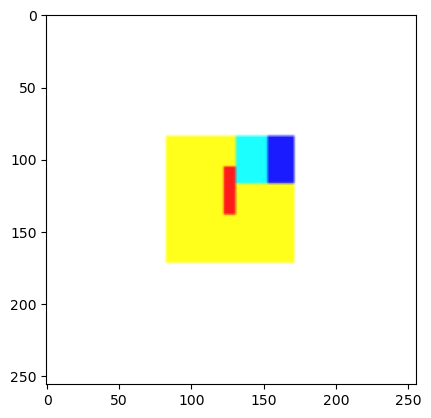

In [11]:
myfile = Path(root + 'dataset/Augmented/B/1b0c14658604.png')
img = skimage.io.imread(myfile)
plt.imshow(img)

In [9]:
vals, counts = np.unique(img.reshape(-1, 4), axis=0, return_counts=True)
thresh = 30
# form a dictionary of values/counts > threshold
out = set(map(tuple, vals[counts>thresh])) 
rmColor = set(map(tuple, rmFuncMap.values()))

print(np.array(list(out.intersection(rmColor))))

# rgb = img[:,:,0:3]
# segments_fz = felzenszwalb(rgb, scale=100, sigma=0.1, min_size=80)
# print(segments_fz.shape)
# print(segments_fz)
# unique_pix_val = np.unique(segments_fz.reshape(-1), axis=0)
# print(unique_pix_val)
# result = mark_boundaries(rgb, segments_fz)
# plt.imshow(result)

[[255  27  27 255]
 [ 27  27 255 255]
 [255 255 255 255]
 [ 27 255 255 255]
 [255 255  27 255]]


[[ 27  27 255 255]
 [ 27 255 255 255]
 [255  27  27 255]
 [255 255  27 255]
 [255 255 255 255]]


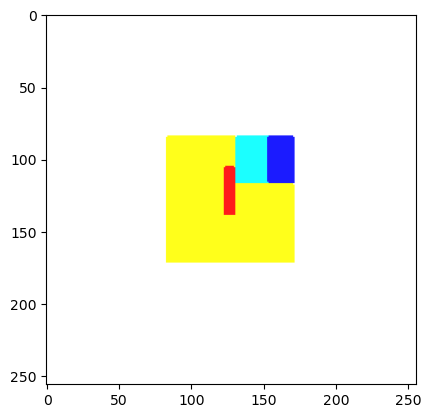

In [12]:
myfile = Path(root + 'dataset/Augmented/B/1b0c14658604.png')
img = skimage.io.imread(myfile)

# img = generateBlWhImg(img.copy())
img = replaceCloestColor(img.copy(), rmFuncMap)
plt.imshow(img)
unique_pix_val = np.unique(img.reshape(-1, 4), axis=0)
print(unique_pix_val)

[[  0   0   0 255]
 [  1   1   1 255]
 [  2   2   2 255]
 ...
 [253 253 253 255]
 [254 254 254 255]
 [255 255 255 255]]


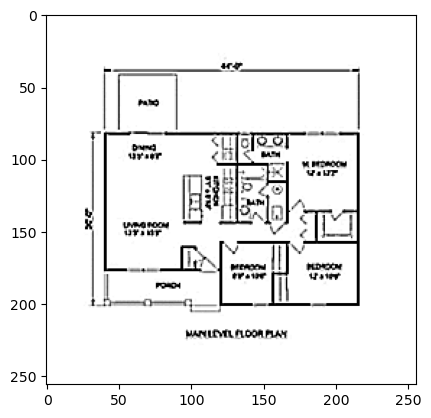

In [13]:
myfile = Path(root + 'dataset/Source Images/0.png')
img = skimage.io.imread(myfile)

# img = generateBlWhImg(img.copy())
img = unblur(img.copy())
plt.imshow(img)
unique_pix_val = np.unique(img.reshape(-1, 4), axis=0)
print(unique_pix_val)

In [ ]:
for path in pathB.glob("*.png"):
    img = skimage.io.imread(path)
    img = replaceCloestColor(img, rmFuncMap)
    # Convert image data to uint8
    # print(img.dtype)
    # print(img.shape)
    img = img.astype(np.uint8)
    # print(img.dtype)
    # print(img.shape)
    skimage.io.imsave(pathB_processed / path.name, img)

In [22]:

for file in pathB_processed.glob("*.png"):
  # im1 = np.full_like(y, [0, 0, 0, 255])
  im2 = skimage.io.imread(file)
  # Create a black image with the same height and channels as im2, but with a desired width
  im1 = np.zeros((im2.shape[0], 100, im2.shape[2]), dtype=im2.dtype)  # Adjust the width (100) as needed
  # im1 = None
  # Combine images horizontally using PIL
  dst = np.hstack((im1, im2))

  # dst = dst.astype(np.uint8)

  skimage.io.imsave(newCombinedPath / file.name, dst)

In [23]:

ratio = 0.15

for file in newCombinedPath.glob("*.png"):
      if np.random.rand(1) < ratio:
          shutil.copyfile(file, test_dir / file.name)
      else:
          shutil.copyfile(file, train_dir / file.name)

In [24]:
os.chdir(str(train_dir))
print(len([name for name in os.listdir('.') if os.path.isfile(name)]))

253


[[  0   0   0   0]
 [ 27  27 255 255]
 [ 27 255  27 255]
 [ 27 255 255 255]
 [255  27  27 255]
 [255  27 255 255]
 [255 155  27 255]
 [255 255  27 255]
 [255 255 255 255]]
(9, 4)


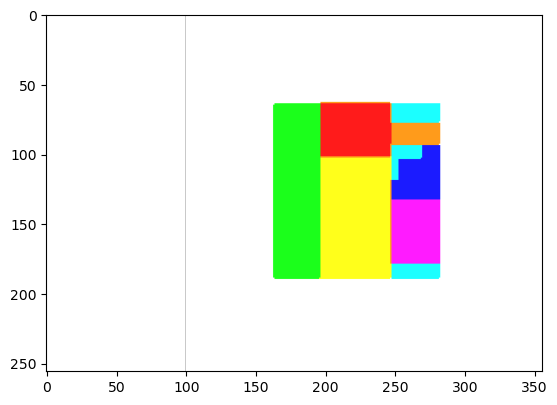

In [32]:
myfile = Path(root + 'dataset/Augmented/Combined_2024_03_06_22_21/Train/0b0be55d43b8.png')
img = skimage.io.imread(myfile)


# Combine images horizontally using PIL
# dst = np.hstack((im1, img))
# plt.imshow(im1)

plt.imshow(img)
unique_pix_val = np.unique(img.reshape(-1, 4), axis=0)
print(unique_pix_val)
print(unique_pix_val.shape)